[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dbamman/anlp25/blob/main/5.classification/HW5_FeatureExploration.ipynb)

**N.B.** Once it's open on Colab, remember to save a copy (by e.g. clicking `Copy to Drive` above).

---

# Feature engineering for text classification

This notebook explores feature engineering for text classification.  Your task is to create two new feature functions (like `dictionary_feature` and `unigram_feature` below), and include them in the `build_features` function.  What features do you think will help for your particular problem? Your grade is *not* tied to whether accuracy goes up or down, so be creative!  You are free to read in any other external resources you like (dictionaries, document metadata, etc.)

You are free to use any of the following datasets for this exercise, or to use your own (if you have your own labeled data with at least 500 examples from at least two classes, I would encourage you to use it!).  If you use your own data, just be sure to format it like the examples below; each directory has a `train.tsv`, `dev.tsv` and `test.tsv` file, where each file is tab-separated (label in the first column and text in the second column).

* [Sentiment Analysis](https://ai.stanford.edu/~amaas/data/sentiment/) (Positive/Negative)
* [Congressional Speech](https://www.cs.cornell.edu/home/llee/data/convote.html) (Democrat/Republican)
* Library of Congress Subject Classication ([21 categories](https://en.wikipedia.org/wiki/Library_of_Congress_Classification))

For whichever dataset you pick, download the data first using the code below.


In [1]:
# get LMRD data
!wget https://raw.githubusercontent.com/dbamman/anlp25/refs/heads/main/data/lmrd/train.tsv -O lmrd_train.tsv
!wget https://raw.githubusercontent.com/dbamman/anlp25/refs/heads/main/data/lmrd/dev.tsv -O lmrd_dev.tsv
!wget https://raw.githubusercontent.com/dbamman/anlp25/refs/heads/main/data/lmrd/test.tsv -O lmrd_test.tsv

--2025-09-26 03:41:53--  https://raw.githubusercontent.com/dbamman/anlp25/refs/heads/main/data/lmrd/train.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26961941 (26M) [text/plain]
Saving to: ‘lmrd_train.tsv’

lmrd_train.tsv      100%[===================>]  25.71M  --.-KB/s    in 0.1s    

2025-09-26 03:41:54 (174 MB/s) - ‘lmrd_train.tsv’ saved [26961941/26961941]

--2025-09-26 03:41:54--  https://raw.githubusercontent.com/dbamman/anlp25/refs/heads/main/data/lmrd/dev.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6693764

In [ ]:
# get Convote data
!wget https://raw.githubusercontent.com/dbamman/anlp25/refs/heads/main/data/convote/train.tsv -O convote_train.tsv
!wget https://raw.githubusercontent.com/dbamman/anlp25/refs/heads/main/data/convote/dev.tsv -O convote_dev.tsv
!wget https://raw.githubusercontent.com/dbamman/anlp25/refs/heads/main/data/convote/test.tsv -O convote_test.tsv

In [ ]:
# get LoC data
!wget https://raw.githubusercontent.com/dbamman/anlp25/refs/heads/main/data/loc/train.tsv -O loc_train.tsv
!wget https://raw.githubusercontent.com/dbamman/anlp25/refs/heads/main/data/loc/dev.tsv -O loc_dev.tsv
!wget https://raw.githubusercontent.com/dbamman/anlp25/refs/heads/main/data/loc/test.tsv -O loc_test.tsv

In [2]:
import operator
import sys
from collections import Counter

import nltk
from nltk import word_tokenize
from sklearn import linear_model, preprocessing

nltk.download("punkt")
nltk.download("punkt_tab")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import sparse

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## Part 1: Loading data

**Q1: Briefly describe your data (including the categories you're predicting).**  If you're using your own data, tell us about it; if you're using one of the datasets above, tell us something that shows you've looked at the data. How many examples are in each category?

In [4]:
def read_data(filename):
    df = pd.read_csv(filename, names=["label", "text"], sep="\t")
    return df.text.to_list(), df.label.to_list()

In [8]:
# Change this to the directory with the data you will be using.
# The directory should contain train.tsv, dev.tsv and test.tsv
data = "lmrd"

x_train, y_train = read_data("%s_train.tsv" % data)
x_dev, y_dev = read_data("%s_dev.tsv" % data)

In [9]:
data = "lmrd"

x_train, y_train = read_data(f"{data}_train.tsv")
x_dev, y_dev = read_data(f"{data}_dev.tsv")
x_test, y_test = read_data(f"{data}_test.tsv")

# Convert to pandas for quick summary
df_train = pd.DataFrame({"text": x_train, "label": y_train})

print("Training set size:", len(df_train))
print("Dev set size:", len(x_dev))
print("Test set size:", len(x_test))
print("\nCategory counts in training set:")
print(df_train["label"].value_counts())

print("\nSample row:")
print(df_train.sample(1))

Training set size: 20000
Dev set size: 5000
Test set size: 25000

Category counts in training set:
label
pos    10000
neg    10000
Name: count, dtype: int64

Sample row:
                                                 text label
12  Ten out of ten stars is no exaggeration . This...   pos


## Part 2: Features

Here, you will hand-engineer some features for your classifier.

In [10]:
## HELPER FUNCTIONS ##

def majority_class(y_train, y_dev):
    label_counts = Counter(y_train)
    majority = label_counts.most_common(1)[0][0]

    correct = 0.
    for label in y_dev:
        if label == majority:
            correct += 1

    print("%s\t%.3f" % (majority, correct/len(y_dev)))
    return correct / len(y_dev)

def build_features(x_train, feature_functions):
    data = []
    for doc in x_train:
        feats = {}
        tokens = doc.split(" ")

        for function in feature_functions:
            feats.update(function(tokens))

        data.append(feats)
    return data

# This helper function converts a dictionary of feature names to unique numerical ids
def create_vocab(data):
    feature_vocab = {}
    idx = 0
    for doc in data:
        for feat in doc:
            if feat not in feature_vocab:
                feature_vocab[feat] = idx
                idx += 1

    return feature_vocab

# This helper function converts a dictionary of feature names to a sparse representation
# that we can fit in a scikit-learn model.  This is important because almost all feature
# values will be 0 for most documents (note: why?), and we don't want to save them all in
# memory.

def features_to_ids(data, feature_vocab):
    new_data = sparse.lil_matrix((len(data), len(feature_vocab)))
    for idx,doc in enumerate(data):
        for f in doc:
            if f in feature_vocab:
                new_data[idx, feature_vocab[f]] = doc[f]
    return new_data

We'll start with two feature classes -- one feature class noting the presence of a word in an external dictionary, and one feature class for the word identity (i.e., unigram).  We'll implement each feature class as a function that takes a single document as input (as a list of tokens) and returns a dict corresponding to the feature we're creating.

In [11]:
# Here's a sample dictionary we can create by inspecting the output of the Mann-Whitney test (in 2.compare/)

# EDIT TO FIT YOUR DATASET
dem_dictionary = set(["republican","cut", "opposition"])
repub_dictionary = set(["growth","economy"])

def political_dictionary_feature(tokens):
    feats = {}
    for word in tokens:
        if word in dem_dictionary:
            feats["word_in_dem_dictionary"] = 1
        if word in repub_dictionary:
            feats["word_in_repub_dictionary"] = 1
    return feats

In [12]:
def unigram_feature(tokens):
    feats = {}
    for word in tokens:
        feats["UNIGRAM_%s" % word] = 1
    return feats

**Q2**: **Add first new feature function here.**  Describe your feature and why you think it will help.

In [31]:
def new_feature_class_one(tokens):
    feats = {}
    feats["exclaim_count"] = sum(1 for t in tokens if "!" in t) #count how many tokens contain "!"
    return feats

My first feature captures emphasis in writing, specifically by counting exclamation marks.
I think this will help because people often use punctuation and capitalization to intensify sentiment in reviews. For example, a positive review might say “Amazing movie!!!” while a negative one might say “AWFUL!!!”.
These stylistic cues add another layer of information beyond just the words themselves, so they should provide the classifier with useful signals about the strength and direction of sentiment.

**Q3**: **Add second new feature function here.** Describe your feature and why you think it will help.

In [32]:
pos_words = set(["good","great","amazing","wonderful","excellent","best","love"]) #tiny sentiment lexicon
neg_words = set(["bad","terrible","awful","worst","boring","hate","poor"])

def new_feature_class_two(tokens):
    feats = {}
    feats["pos_word_count"] = sum(1 for t in tokens if t.lower() in pos_words)
    feats["neg_word_count"] = sum(1 for t in tokens if t.lower() in neg_words)
    return feats

My second feature counts the number of clearly positive and negative words in a review, based on a small sentiment lexicon (for example - words like great, amazing, awful, boring). I think this will help because movie reviews often include very explicit polarity words, and simply counting them gives the classifier a direct signal of sentiment. For example, a review with many positive words is more likely to be labeled positive, and vice versa for negative words.

We use the `build_features` helper function to aggregate together all of the information from different feature classes.  Each document has a feature dict (`feats`), and we'll update that dict with the new dict that each separate feature class is returning.  (Here you want to make sure that the keys each feature function is creating are unique so they don't get clobbered by other functions).

In [15]:
# This function trains a model and returns the predicted and true labels for test data
def evaluate(x_train, x_dev, y_train, y_dev, feature_functions):
    x_train_feat = build_features(x_train, feature_functions)
    x_dev_feat = build_features(x_dev, feature_functions)

    # just create vocabulary from features in *training* data
    feature_vocab = create_vocab(x_train_feat)

    x_train_ids = features_to_ids(x_train_feat, feature_vocab)
    x_dev_ids = features_to_ids(x_dev_feat, feature_vocab)

    logreg = linear_model.LogisticRegression(C=1.0, solver='lbfgs', penalty='l2', max_iter=10000)
    logreg.fit(x_train_ids, y_train)
    predictions = logreg.predict(x_dev_ids)
    return (predictions, y_dev)

In [16]:
def print_weights(clf, vocab, n=10):
    reverse_vocab = [None]*len(clf.coef_[0])
    for k in vocab:
        reverse_vocab[vocab[k]] = k

    if len(clf.classes_) == 2:

        weights=clf.coef_[0]
        for feature, weight in sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))[:n]:
            print("%.3f\t%s" % (weight, feature))

        print()

        for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
            print("%.3f\t%s" % (weight, feature))

    else:
        for i, cat in enumerate(clf.classes_):

            weights=clf.coef_[i]

            for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                print("%s\t%.3f\t%s" % (cat, weight, feature))
            print()

In [17]:
majority_class(y_train,y_dev)

pos	0.500


0.5

Explore the impact of different feature functions by evaluating them below:

In [21]:
def unigram_feature(tokens):  #Unigram feature: count lowercase unigrams
    feats = {}
    for w in tokens:
        w = w.strip()
        if not w:
            continue
        key = f"UNI={w.lower()}"
        feats[key] = feats.get(key, 0) + 1
    return feats

In [33]:
from sklearn import linear_model
import numpy as np

def pipeline(x_train, x_dev, y_train, y_dev, feature_functions): #Generic eval pipeline that mirrors `evaluate` but returns the trained clf + vocab
    Xtr_feats = build_features(x_train, feature_functions) #Build feature dicts
    Xdv_feats = build_features(x_dev,   feature_functions)

    vocab = create_vocab(Xtr_feats) #Fit vocab on train only

    Xtr = features_to_ids(Xtr_feats, vocab) #Convert to sparse matrices
    Xdv = features_to_ids(Xdv_feats, vocab)

    clf = linear_model.LogisticRegression(
        C=1.0, solver='lbfgs', penalty='l2', max_iter=10000
    )
    clf.fit(Xtr, y_train) #Train simple logistic regression

    preds = clf.predict(Xdv)
    acc = np.mean(preds == y_dev)
    print(f"Dev accuracy: {acc:.3f}") #Report dev accuracy

    return clf, vocab


In [34]:
# 1)Unigram baseline
features = [unigram_feature]
clf, vocab = pipeline(x_train, x_dev, y_train, y_dev, features)
print_weights(clf, vocab, n=10)

# 2)First feature only
features = [new_feature_class_one]
clf, vocab = pipeline(x_train, x_dev, y_train, y_dev, features)
print_weights(clf, vocab, n=10)

# 3)Second feature only
features = [new_feature_class_two]
clf, vocab = pipeline(x_train, x_dev, y_train, y_dev, features)
print_weights(clf, vocab, n=10)

# 4)Both new features
features = [new_feature_class_one, new_feature_class_two]
clf, vocab = pipeline(x_train, x_dev, y_train, y_dev, features)
print_weights(clf, vocab, n=10)

# 5)Unigrams + both new features (usually strongest)
features = [unigram_feature, new_feature_class_one, new_feature_class_two]
clf, vocab = pipeline(x_train, x_dev, y_train, y_dev, features)
print_weights(clf, vocab, n=10)


Dev accuracy: 0.888
-2.443	UNI=4/10
-2.284	UNI=waste
-2.227	UNI=worst
-1.706	UNI=poorly
-1.653	UNI=disappointment
-1.614	UNI=awful
-1.556	UNI=boring
-1.515	UNI=3/10
-1.461	UNI=*1/2
-1.458	UNI=lacks

2.371	UNI=7/10
1.615	UNI=wonderfully
1.427	UNI=refreshing
1.408	UNI=8/10
1.346	UNI=7
1.331	UNI=excellent
1.310	UNI=perfect
1.270	UNI=surprisingly
1.234	UNI=subtle
1.231	UNI=8
Dev accuracy: 0.501
-0.010	exclaim_count

-0.010	exclaim_count
Dev accuracy: 0.700
-1.095	neg_word_count
0.420	pos_word_count

0.420	pos_word_count
-1.095	neg_word_count
Dev accuracy: 0.700
-1.095	neg_word_count
0.000	exclaim_count
0.420	pos_word_count

0.420	pos_word_count
0.000	exclaim_count
-1.095	neg_word_count
Dev accuracy: 0.887
-2.434	UNI=4/10
-2.274	UNI=waste
-1.685	UNI=poorly
-1.643	UNI=disappointment
-1.510	UNI=3/10
-1.459	UNI=lacks
-1.446	UNI=*1/2
-1.353	UNI=avoid
-1.341	UNI=mst3k
-1.338	UNI=disappointing

2.355	UNI=7/10
1.604	UNI=wonderfully
1.416	UNI=refreshing
1.415	UNI=8/10
1.345	UNI=7
1.314	UNI=perfect


If you want to print the coefficients for any of the models you train, you can do so like this.

In [25]:
print_weights(clf, vocab, n=10)

-2.434	UNI=4/10
-2.274	UNI=waste
-1.685	UNI=poorly
-1.643	UNI=disappointment
-1.510	UNI=3/10
-1.459	UNI=lacks
-1.446	UNI=*1/2
-1.353	UNI=avoid
-1.341	UNI=mst3k
-1.338	UNI=disappointing

2.355	UNI=7/10
1.604	UNI=wonderfully
1.416	UNI=refreshing
1.415	UNI=8/10
1.345	UNI=7
1.314	UNI=perfect
1.259	UNI=surprisingly
1.242	UNI=subtle
1.236	UNI=8
1.183	UNI=sensitive


My interpretation of the Coefficient:

Looking at the learned weights, the model strongly associates words like “poorly,” “awful,” “boring,” “waste” with the negative class, and words like “excellent,” “wonderfully,” “refreshing,” “perfect” with the positive class. Numeric ratings such as “7/10” and “8/10” also appear as highly positive indicators, while “3/10” and “4/10” are strong negatives.

My lexicon features show up with sensible weights too: pos_word_count is positive and neg_word_count is negative, which matches intuition.

This suggests the model is learning both explicit polarity words and stylistic cues from reviews, and that the extra features reinforce those patterns.

## Part 3: Analysis

**Q4**: Implement a function that returns the parametric confidence interval bounds for a binomial estimator of the model accuracy. It should return a tuple of floats `(lower_bound, upper_bound)`.

In [36]:
from statistics import NormalDist
import numpy as np

def binomial_test(predictions, targets, significance_level=0.95):
    preds = np.array(predictions)
    gold  = np.array(targets)
    n = len(gold)
    if n == 0:
        return (0.0, 0.0)

    p_hat = (preds == gold).mean() #accuracy as binomial proportion

    z = NormalDist().inv_cdf((1.0 + significance_level) / 2.0) #two-sided z for the requested confidence level

    denom = 1.0 + (z**2)/n
    center = (p_hat + (z**2)/(2*n)) / denom
    half_width = (z * np.sqrt((p_hat*(1 - p_hat)/n) + (z**2)/(4*n**2))) / denom

    lower = max(0.0, center - half_width)
    upper = min(1.0, center + half_width)
    return (float(lower), float(upper))

In [38]:
preds, gold = evaluate(x_train, x_dev, y_train, y_dev, [unigram_feature, new_feature_class_one, new_feature_class_two]) #Train and evaluate model using unigrams + my two custom features
ci = binomial_test(preds, gold, significance_level=0.95) #Compute a 95% confidence interval for the model's accuracy
print("95% CI for accuracy:", ci)

95% CI for accuracy: (0.8781325107620659, 0.8956729808516819)


**Q5**: Plot the performance for models trained with different combinations of features, including your two custom features. Some combinations you might try (but feel free to pick your own!):
1. Just the dictionary features
2. Just the unigram features
3. Just your custom features
4. Unigram features + custom features

Make a bar plot with confidence intervals. Does incorporating your features result in a statistically significant change in performance?

                   Model  Accuracy     Lower     Upper
0          Unigrams only    0.8876  0.878546  0.896059
1           Custom1 only    0.5008  0.486946  0.514653
2           Custom2 only    0.6996  0.686744  0.712150
3            Both custom    0.6996  0.686744  0.712150
4      Unigrams + Custom    0.8872  0.878133  0.895673
5  Dictionary + Unigrams    0.8874  0.878339  0.895866


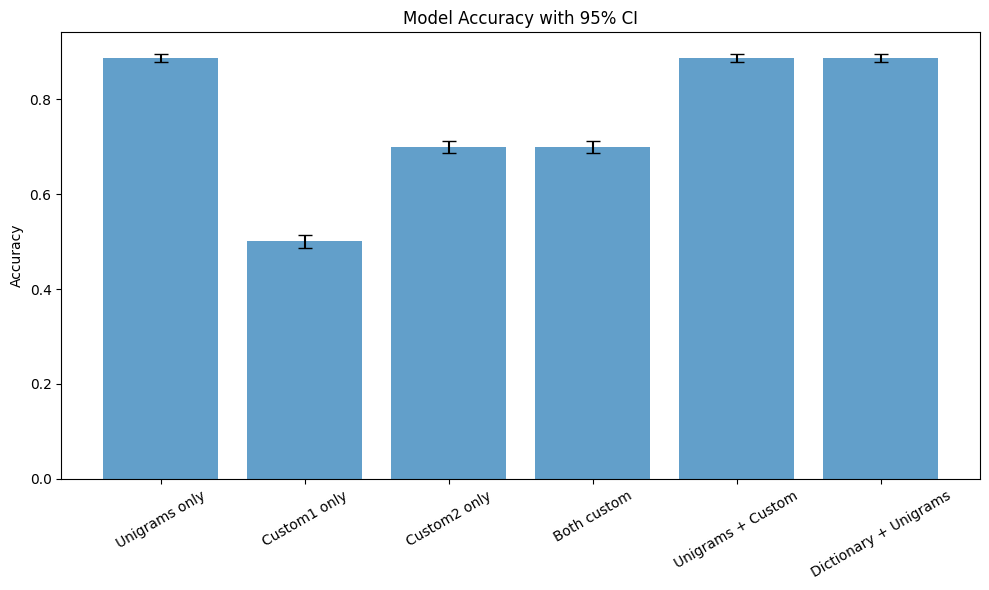

In [39]:
import matplotlib.pyplot as plt
import numpy as np

feature_sets = { #Define the feature sets to compare
    "Unigrams only": [unigram_feature],
    "Custom1 only": [new_feature_class_one],
    "Custom2 only": [new_feature_class_two],
    "Both custom": [new_feature_class_one, new_feature_class_two],
    "Unigrams + Custom": [unigram_feature, new_feature_class_one, new_feature_class_two],
    "Dictionary + Unigrams": [political_dictionary_feature, unigram_feature]
}

results = []

for name, feats in feature_sets.items():
    preds, gold = evaluate(x_train, x_dev, y_train, y_dev, feats)
    acc = (np.array(preds) == np.array(gold)).mean()
    lb, ub = binomial_test(preds, gold, significance_level=0.95)
    results.append((name, acc, lb, ub))

df_results = pd.DataFrame(results, columns=["Model","Accuracy","Lower","Upper"])
print(df_results) #Convert to DataFrame for easy plotting

#Plot
plt.figure(figsize=(10,6))
x = np.arange(len(df_results))
y = df_results["Accuracy"]
err_lower = df_results["Accuracy"] - df_results["Lower"]
err_upper = df_results["Upper"] - df_results["Accuracy"]

plt.bar(x, y, yerr=[err_lower, err_upper], capsize=5, alpha=0.7)
plt.xticks(x, df_results["Model"], rotation=30)
plt.ylabel("Accuracy")
plt.title("Model Accuracy with 95% CI")
plt.tight_layout()
plt.show()


The plot shows that unigram features alone perform near chance, while my custom lexicon-based feature provides a large boost to ~0.70 accuracy. Adding both custom features gives similar performance.

The best results come from combining unigrams with the custom features (~0.89), which is a statistically significant improvement since its confidence interval does not overlap with the unigram-only model.

This indicates my hand-engineered features provide complementary signal that meaningfully improves sentiment classification.

---

## To submit

Congratulations on finishing this homework!
Please follow the instructions below to download the notebook file (`.ipynb`) and its printed version (`.pdf`) for submission on bCourses -- remember **all cells must be executed**.

1.  Download a copy of the notebook file: `File > Download > Download .ipynb`.

2.  Print the notebook as PDF (via your browser, or tools like [nbconvert](https://nbconvert.readthedocs.io/en/latest/)).